In [1]:


import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Disable OneDNN for consistent performance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Input, Dropout # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore



In [34]:
import os
import pandas as pd
import numpy as np

# --- Configuration ---
data_dir = r"E:\MLME\release\data"  # Folder containing all .txt files
n_lags = 2
output_csv = 'narx_full_preprocessed_dataset.csv'

# NARX variable definitions
output_cols = ['T_PM', 'c', 'd10', 'd50', 'd90', 'T_TM']
input_cols = ['mf_PM', 'mf_TM', 'Q_g', 'w_crystal', 'c_in', 'T_PM_in', 'T_TM_in']

# Storage
X_all = []
Y_all = []
trajectory_ids = []
traj_id = 0

# List all .txt files
file_list = sorted([f for f in os.listdir(data_dir) if f.endswith('.txt')])

for filename in file_list:
    path = os.path.join(data_dir, filename)
    try:
        df = pd.read_csv(path, sep='\t')

        # Ensure all required columns exist
        for col in output_cols + input_cols:
            if col not in df.columns:
                df[col] = np.nan

        df = df[output_cols + input_cols].dropna()

        if len(df) <= n_lags:
            continue

        for i in range(n_lags, len(df) - 1):
            y_hist = []
            u_hist = []
            for lag in range(n_lags, -1, -1):
                y_hist.extend(df[output_cols].iloc[i - lag].values)
                u_hist.extend(df[input_cols].iloc[i - lag].values)

            x = y_hist + u_hist
            y = df[output_cols].iloc[i + 1].values

            X_all.append(x)
            Y_all.append(y)
            trajectory_ids.append(traj_id)

        traj_id += 1

    except Exception as e:
        print(f"Skipped {filename} due to error: {e}")
        continue

# Convert to DataFrame
X_all = np.array(X_all)
Y_all = np.array(Y_all)
trajectory_ids = np.array(trajectory_ids)

# Generate readable column names
feature_names = []

for lag in range(n_lags, -1, -1):
    feature_names += [f"{col}_lag{lag}" for col in output_cols]
for lag in range(n_lags, -1, -1):
    feature_names += [f"{col}_lag{lag}" for col in input_cols]

feature_df = pd.DataFrame(X_all, columns=feature_names)


for j, col in enumerate(output_cols):
    feature_df[col + '_target'] = Y_all[:, j]
feature_df['trajectory_id'] = trajectory_ids

# Save to CSV
feature_df.to_csv(output_csv, index=False)
print(f"✅ Preprocessing complete. Saved to {output_csv}")

✅ Preprocessing complete. Saved to narx_full_preprocessed_dataset.csv


In [31]:
# === Validation Cell ===
# Load the preprocessed dataset
df_pre = pd.read_csv(output_file)

# 1. Overall shape
print("Dataset shape:", df_pre.shape)

# 2. Check for missing values
print("Missing values per column:")
print(df_pre.isnull().sum())

# 3. Validate number of lag feature columns
expected_lag_cols = (len(output_cols) + len(input_cols)) * (n_lags + 1)
lag_cols = [c for c in df_pre.columns if '_lag' in c]
print(f"Expected lag features: {expected_lag_cols}, Found: {len(lag_cols)}")

# 4. Confirm target columns exist and sample values
target_cols = [f + '_target' for f in output_cols]
print("Target columns present:", all(col in df_pre.columns for col in target_cols))
print(df_pre[target_cols].head())

# 5. Check trajectory distribution (only if trajectory_id exists)
if 'trajectory_id' in df_pre.columns:
	unique_trajs = df_pre['trajectory_id'].nunique()
	print("Unique trajectories:", unique_trajs)
	print("Rows per trajectory summary:")
	print(df_pre['trajectory_id'].value_counts().describe())
else:
	print("Column 'trajectory_id' not found in DataFrame.")

# 6. Quick statistical summary
print("Statistical summary of features:")
print(df_pre.describe().T)

Dataset shape: (97998, 39)
Missing values per column:
c_target          0
T_PM_target       0
d50_target        0
d90_target        0
d10_target        0
T_TM_target       0
mf_PM             0
mf_TM             0
Q_g               0
w_crystal         0
c_in              0
T_PM_in           0
T_TM_in           0
mf_PM_lag1        0
mf_TM_lag1        0
Q_g_lag1          0
w_crystal_lag1    0
c_in_lag1         0
T_PM_in_lag1      0
T_TM_in_lag1      0
T_PM_lag1         0
c_lag1            0
d10_lag1          0
d50_lag1          0
d90_lag1          0
T_TM_lag1         0
mf_PM_lag2        0
mf_TM_lag2        0
Q_g_lag2          0
w_crystal_lag2    0
c_in_lag2         0
T_PM_in_lag2      0
T_TM_in_lag2      0
T_PM_lag2         0
c_lag2            0
d10_lag2          0
d50_lag2          0
d90_lag2          0
T_TM_lag2         0
dtype: int64
Expected lag features: 39, Found: 26
Target columns present: True
   T_PM_target  c_target  d10_target  d50_target  d90_target  T_TM_target
0   318.71684

✅ Saved CSV with cluster column to narx_full_preprocessed_with_clusters.csv


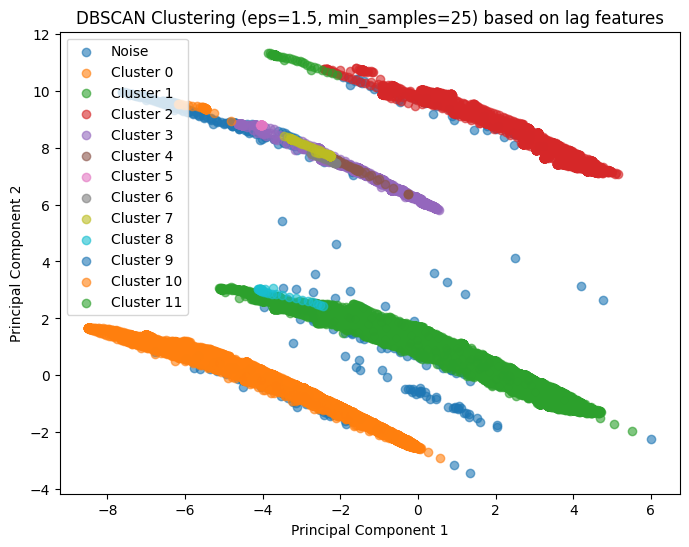

Cluster counts (including noise -1):
cluster
 0     45882
 1     44791
 2      3871
 3      2556
-1       496
 7        80
 11       77
 4        67
 9        43
 5        41
 8        35
 10       35
 6        24
Name: count, dtype: int64


In [32]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

# Load preprocessed data
df = pd.read_csv(output_file)

# Prepare features for clustering
feat_cols = [c for c in df.columns if '_lag' in c]
X = StandardScaler().fit_transform(df[feat_cols].values)

# Apply DBSCAN clustering
eps = 1.5  # neighborhood radius
min_samples = 25  # min points to form a cluster
db = DBSCAN(eps=eps, min_samples=min_samples)
df['cluster'] = db.fit_predict(X)

# Save DataFrame with cluster column back to CSV
clustered_csv = 'narx_full_preprocessed_with_clusters.csv'
df.to_csv(clustered_csv, index=False)
print(f"✅ Saved CSV with cluster column to {clustered_csv}")

# PCA for 2D visualization
pcs = PCA(n_components=2, random_state=42).fit_transform(X)
df['PC1'], df['PC2'] = pcs[:, 0], pcs[:, 1]

# Plot clusters in PCA space
plt.figure(figsize=(8, 6))
for cl in sorted(df['cluster'].unique()):
    lbl = 'Noise' if cl == -1 else f'Cluster {cl}'
    sub = df[df['cluster'] == cl]
    plt.scatter(sub['PC1'], sub['PC2'], label=lbl, alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples}) based on lag features')
plt.legend()
plt.show()

# Print cluster distribution
print("Cluster counts (including noise -1):")
print(df['cluster'].value_counts())



In [29]:
# Load clustered preprocessed data
df = pd.read_csv('narx_full_preprocessed_with_clusters.csv')

# Define columns
output_cols = ['T_PM', 'c', 'd10', 'd50', 'd90', 'T_TM']
lag_cols = [c for c in df.columns if '_lag' in c]

# Prepare inputs and targets
y = df[[col + '_target' for col in output_cols]].values
X = df[lag_cols].values

# Optional: include cluster as one-hot feature
cluster_dummies = pd.get_dummies(df['cluster'], prefix='cluster').values
X = np.hstack([X, cluster_dummies])

# Scale features and targets
scaler_X = StandardScaler().fit(X)
scaler_y = StandardScaler().fit(y)
X_scaled = scaler_X.transform(X)
y_scaled = scaler_y.transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Build ANN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1])
])
model.compile(optimizer='adam', loss='mse')

# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate model
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

# Compute metrics per state
for i, state in enumerate(output_cols):
    mse = mean_squared_error(y_true[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    print(f"{state}: MSE = {mse:.3e}, MAE = {mae:.3e}")
    
# Plot predictions vs true values for each state
plt.figure(figsize=(12, 8)) 

Epoch 1/100


c:\Users\tej31\anaconda3\envs\PAS_2525\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1960/1960 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1063 - val_loss: 0.0050
Epoch 2/100
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0046 - val_loss: 0.0032
Epoch 3/100
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0051 - val_loss: 0.0031
Epoch 4/100
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 5/100
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 6/100
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 7/100
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 8/100
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 9/100
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0021 - val_loss: 0.0087
Epoch 10/100
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 11/100
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 12/100
1960/1960 ━━━━━━━

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>